In [3]:
import torch 
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

In [4]:
# LOADING OLED DATA # 
data_path1 = r'C:\Users\A\Desktop\IITGN\OLED_project\supporting data\EQE_data.xlsx'
data_path2 = r'C:\Users\A\Desktop\IITGN\OLED_project\supporting data\EQE'
data_path3 = r'C:\Users\A\Desktop\IITGN\OLED_project\supporting data\predicted_EQE_data.xlsx'

data = pd.read_excel(data_path1)

string_headers = ['Name', 'Name.1', 'Name.2', 'Name.3', 'Name.4']
null_indices = []
for i in string_headers:
    N = data[data[i].isnull()].index
    for j in N:
        null_indices.append(int(j))
    
null_indices = set(null_indices)
null_indices = pd.DataFrame(null_indices)
null_indices.columns = ['Null Indices']
null_indices.to_excel(data_path3, header=True)

for i in string_headers:
   data = data[data[i].notna()]

data = data.fillna(0)
data.to_excel(data_path2, header=True)
data.head()

NameError: name 'data_path2' is not defined

In [ ]:
# IMPORTING ML ALGORITHMS # 

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
# BREAKING THE DATA AND SELECTING FEATURES, PREDICTORS # 

from sklearn.model_selection import train_test_split
predictors = data.drop(['Name', 'Name.1', 'Name.2', 'Name.3', 'Name.4', 'EQE'], axis=1)
target = data['EQE']
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.23, random_state=1)

In [5]:
# COMPARING SCORES # 
algos = [LinearRegression, RandomForestRegressor, Lasso, GradientBoostingRegressor, KNeighborsRegressor]
s1, s2 = [], []

def scores(i):
    mod = i()
    mod.fit(x_train, y_train)
    y_pred = mod.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    s1.append(r2)
    s2.append(rmse)
    
for i in algos:
    scores(i)

NameError: name 'LinearRegression' is not defined

In [4]:
# CHECKING SCORES # 

models = pd.DataFrame({'Method' : ['LinearRegression', 'RandomForestRegressor', 'Lasso', 'GradientBoostingRegressor', 'KNeighborsRegressor'],
                      'r2_score' : [s1[0], s1[1], s1[2], s1[3], s1[4]],
                      'RMSE' : [s2[0], s2[1], s2[2], s2[3], s2[4]]},  
                      set(np.arange(1, len(algos) + 1)))

models = models.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display(models)

NameError: name 's1' is not defined

## Using Gradient Descent 

In [222]:
Nrows, Ncols = data.shape[0], data.shape[1]
w_cols = predictors.shape[1]

mod_predictors = torch.tensor(predictors.values)
mod_targets = torch.tensor(target.values)

weights = torch.rand(w_cols, 1, requires_grad=True)
biases = torch.rand(Nrows, 1, requires_grad=True)

In [223]:
# Creating a model that returns EQE values #
def model(x):
    global weights, biases
    return torch.matmul(x, weights) + biases

#  Calculating RMSE value between two vectors #
def rmse(vector1, vector2):
    diff = vector1 - vector2 
    return torch.sqrt(torch.sum(diff * diff) / diff.numel())

In [224]:
# Computing Gradient # 

for i in range(50000):
    predicted_EQE = model(mod_predictors.float())
    loss = rmse(predicted_EQE, mod_targets)
    loss.backward()
    with torch.no_grad():
        weights -= weights.grad * 1e-5
        biases -= biases.grad * 1e-5
        weights.grad.zero_()
        biases.grad.zero_()

print(f'RMSE (custom_program) : {loss}')

tensor(7.1059, dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [225]:
predicted_EQE = predicted_EQE.detach().numpy().reshape(Nrows)

In [226]:
EQE1 = predicted_EQE 

RF = RandomForestRegressor()
RF.fit(x_train, y_train)
EQE2 = RF.predict(predictors)

EQE_compare = pd.DataFrame({'ID' : np.arange(1, Nrows+1),'TADF Emitter' : data['Name'], 'EQE' : data['EQE'],
                            'DenishRegressor' :  EQE1, 'LinearRegressor' : EQE2})
EQE_compare.head(Nrows)

,ID,TADF Emitter,EQE,DenishRegressor,LinearRegressor
2,1,CzDB A,30.5,9.785842,27.9919
3,2,5CZ- TRZ,29.3,14.414145,26.4837
4,3,TmCZ-TRZ,19.7,14.233106,21.8290
5,4,DAC T-II,24.3,14.024307,21.9060
6,5,TDB A–Ac,21.5,18.611145,21.7414
...,...,...,...,...,...
259,124,2PXZ-TAZ,5.0,17.126122,9.2390
268,125,Cz- TRZ1,7.2,18.356728,10.1530
269,126,Cz- TRZ2,22.0,16.812527,21.9636
270,127,Cz- TRZ3,19.2,16.903461,18.2541


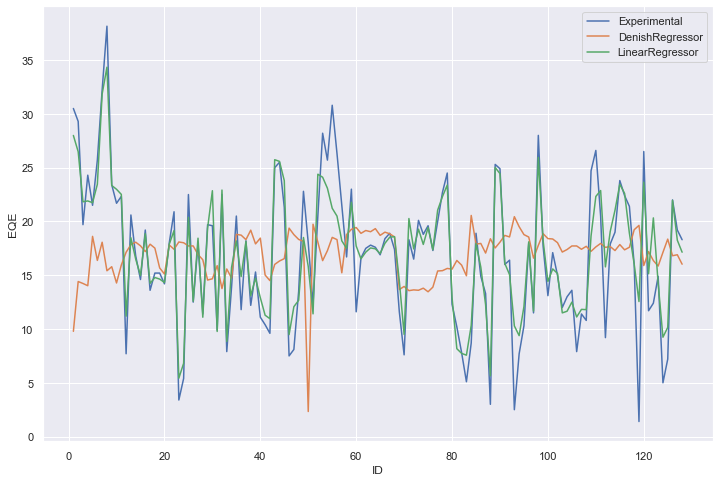

In [227]:
sns.set_theme()
plt.figure(figsize=(12, 8))
sns.lineplot(x='ID', y='EQE', data=EQE_compare, label="Experimental")
sns.lineplot(x='ID', y='DenishRegressor', data=EQE_compare, label="DenishRegressor")
sns.lineplot(x='ID', y='LinearRegressor', data=EQE_compare, label="LinearRegressor")
plt.show()